In [16]:
! pip install wfdb


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\rouna\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


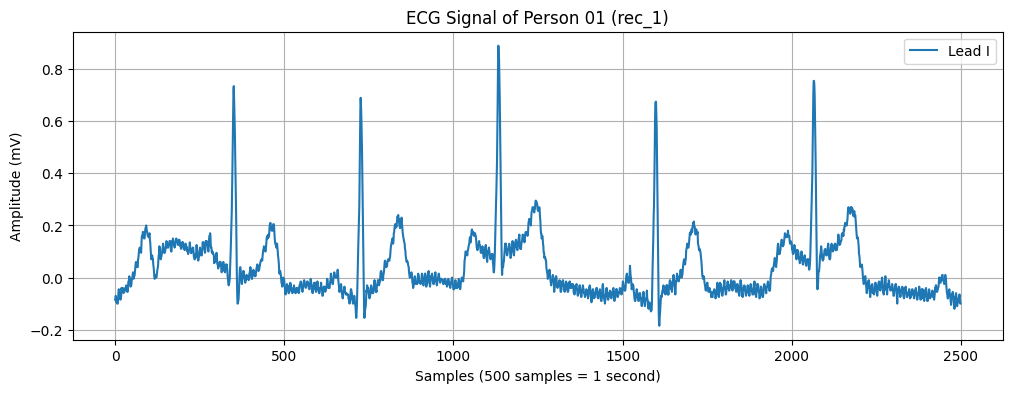

In [1]:
import wfdb
import matplotlib.pyplot as plt
import os

# Path where the dataset is downloaded
dataset_path = 'ecg-id-database-1.0.0'  # change this

# Example: Person_01 recording 1
record_name = os.path.join(dataset_path, "person_01/rec_1")

# Load the signal
signal, fields = wfdb.rdsamp(record_name)

# Plot the first 5 seconds (500 Hz → 2500 samples)
plt.figure(figsize=(12, 4))
plt.plot(signal[:2500, 0], label='Lead I')
plt.title("ECG Signal of Person 01 (rec_1)")
plt.xlabel("Samples (500 samples = 1 second)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
! pip install neurokit2


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\rouna\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


R-peak locations: [ 351  727 1134 1598 2066 2524 2991 3436 3869 4292 4707 5117 5496 5864
 6224 6587 6958 7346 7734 8135 8544 8971 9396 9823]


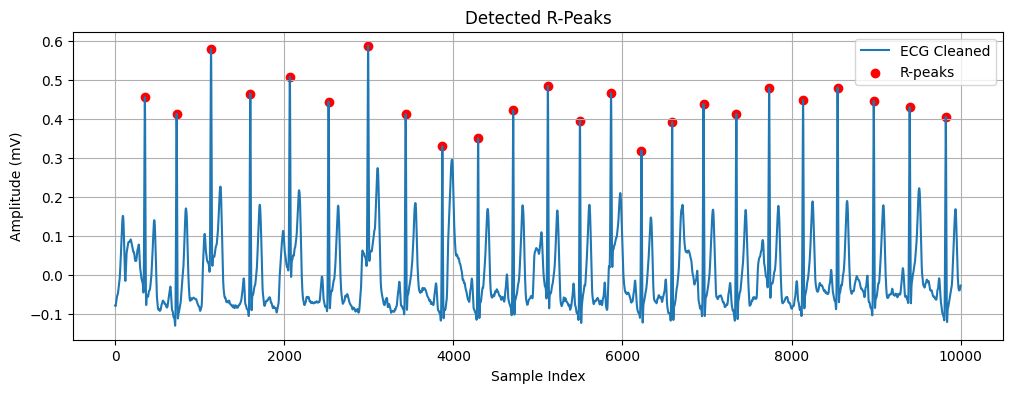

In [2]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os

# Step 1: Load ECG signal
dataset_path = r'c:/Work/ECG-Biometric-Auth/ecg-id-database-1.0.0'
record_name = os.path.join(dataset_path, "person_01", "rec_1")
signal, fields = wfdb.rdsamp(record_name)
ecg_signal = signal[:, 0]
fs = fields['fs']  # should be 500 Hz

# Step 2: Use neurokit2 to detect R-peaks
ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=fs)
_, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)

print("R-peak locations:", rpeaks['ECG_R_Peaks'])

# Step 3: Visualize R-peaks on the signal
plt.figure(figsize=(12, 4))
plt.plot(ecg_cleaned, label='ECG Cleaned')
plt.scatter(rpeaks['ECG_R_Peaks'], ecg_cleaned[rpeaks['ECG_R_Peaks']], color='red', label='R-peaks')
plt.title("Detected R-Peaks")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
# Window size around R-peaks (100 before, 200 after)
beats = []
for r in rpeaks['ECG_R_Peaks']:
    if r - 100 >= 0 and r + 200 < len(ecg_cleaned):
        beat = ecg_cleaned[r - 100: r + 200]
        beats.append(beat)

beats = np.array(beats)  # shape: (num_beats, 300)

print(f"Extracted {beats.shape[0]} heartbeats, each of length {beats.shape[1]} samples")


Extracted 23 heartbeats, each of length 300 samples


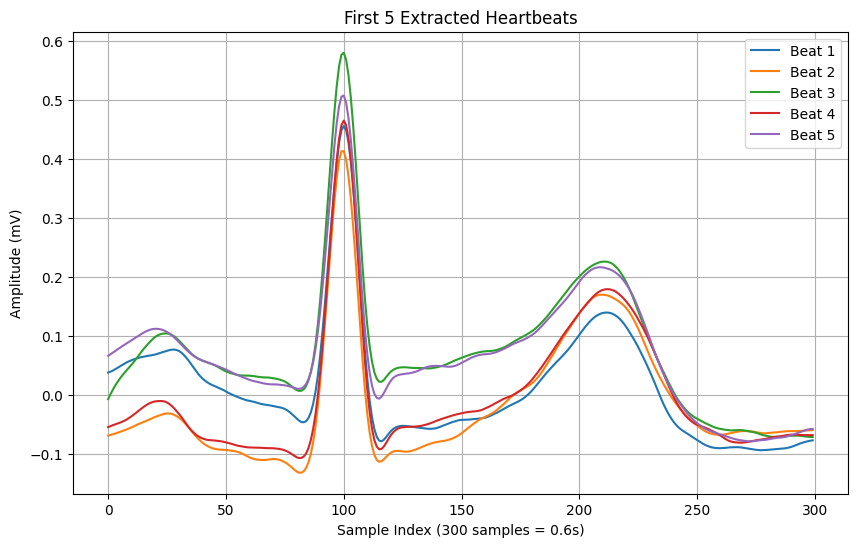

In [4]:
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(beats[i], label=f'Beat {i+1}')
plt.title("First 5 Extracted Heartbeats")
plt.xlabel("Sample Index (300 samples = 0.6s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.legend()
plt.show()


In [22]:
! pip install tqdm


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\rouna\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import os
import numpy as np
import wfdb
from scipy.signal import find_peaks
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Parameters
DATASET_PATH = 'ecg-id-database-1.0.0'
WINDOW_SIZE = 300  # samples (0.6s window around R-peaks)
SAMPLING_RATE = 500  # Hz

all_beats = []
all_labels = []

def extract_beats(signal, r_peaks, window_size):
    half_window = window_size // 2
    beats = []
    for r in r_peaks:
        if r - half_window >= 0 and r + half_window < len(signal):
            beat = signal[r - half_window : r + half_window]
            beats.append(beat)
    return beats

def detect_r_peaks(signal):
    # Basic R-peak detection using simple peak finding
    signal_1d = signal[:, 0]  # Assuming Lead I
    peaks, _ = find_peaks(signal_1d, distance=SAMPLING_RATE*0.6, height=np.mean(signal_1d)+0.5*np.std(signal_1d))
    return peaks

# Loop through dataset
people = sorted(os.listdir(DATASET_PATH))
for person in tqdm(people, desc="Processing Persons"):
    person_path = os.path.join(DATASET_PATH, person)
    if not os.path.isdir(person_path):
        continue

    recordings = sorted([f.split('.')[0] for f in os.listdir(person_path) if f.endswith('.dat')])
    
    for rec in recordings:
        rec_path = os.path.join(person_path, rec)
        try:
            signal, _ = wfdb.rdsamp(rec_path)
            r_peaks = detect_r_peaks(signal)

            beats = extract_beats(signal[:, 0], r_peaks, WINDOW_SIZE)
            all_beats.extend(beats)
            all_labels.extend([person] * len(beats))

        except Exception as e:
            print(f"Error reading {rec_path}: {e}")
            continue

# Convert to numpy
X = np.array(all_beats)  # shape: (num_beats, 300)
y = np.array(all_labels)

# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Save
np.save('X.npy', X)
np.save('y.npy', y_encoded)

print(f"\n✅ Saved: {X.shape[0]} beats from {len(set(y))} persons")


Processing Persons: 100%|██████████| 97/97 [00:11<00:00,  8.66it/s]


✅ Saved: 7117 beats from 90 persons


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load the heartbeat signals and labels
X = np.load("X.npy")
y = np.load("y.npy")

print("X shape:", X.shape)  # (7117, 300)
print("y shape:", y.shape)  # (7117,)


X shape: (7117, 300)
y shape: (7117,)


In [7]:
print(f"Total beats: {X.shape[0]}")
print(f"Length of each beat: {X.shape[1]} samples")

num_classes = len(np.unique(y))
print(f"Number of unique persons: {num_classes}")


Total beats: 7117
Length of each beat: 300 samples
Number of unique persons: 90


C:\Users\rouna\AppData\Local\Temp\ipykernel_15916\3926934393.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_df.index, y=counts_df['Beats'], palette='viridis')


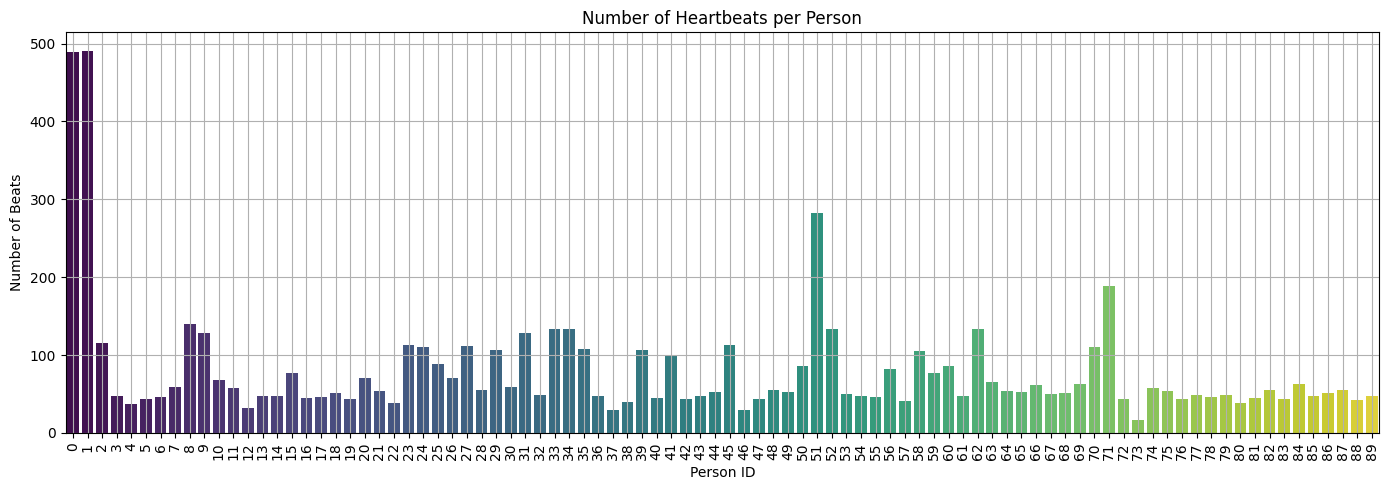

In [8]:
import seaborn as sns
import pandas as pd

class_counts = Counter(y)
counts_df = pd.DataFrame.from_dict(class_counts, orient='index').sort_index()
counts_df.columns = ['Beats']
counts_df.index.name = 'Person ID'

plt.figure(figsize=(14, 5))
sns.barplot(x=counts_df.index, y=counts_df['Beats'], palette='viridis')
plt.title("Number of Heartbeats per Person")
plt.xlabel("Person ID")
plt.ylabel("Number of Beats")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


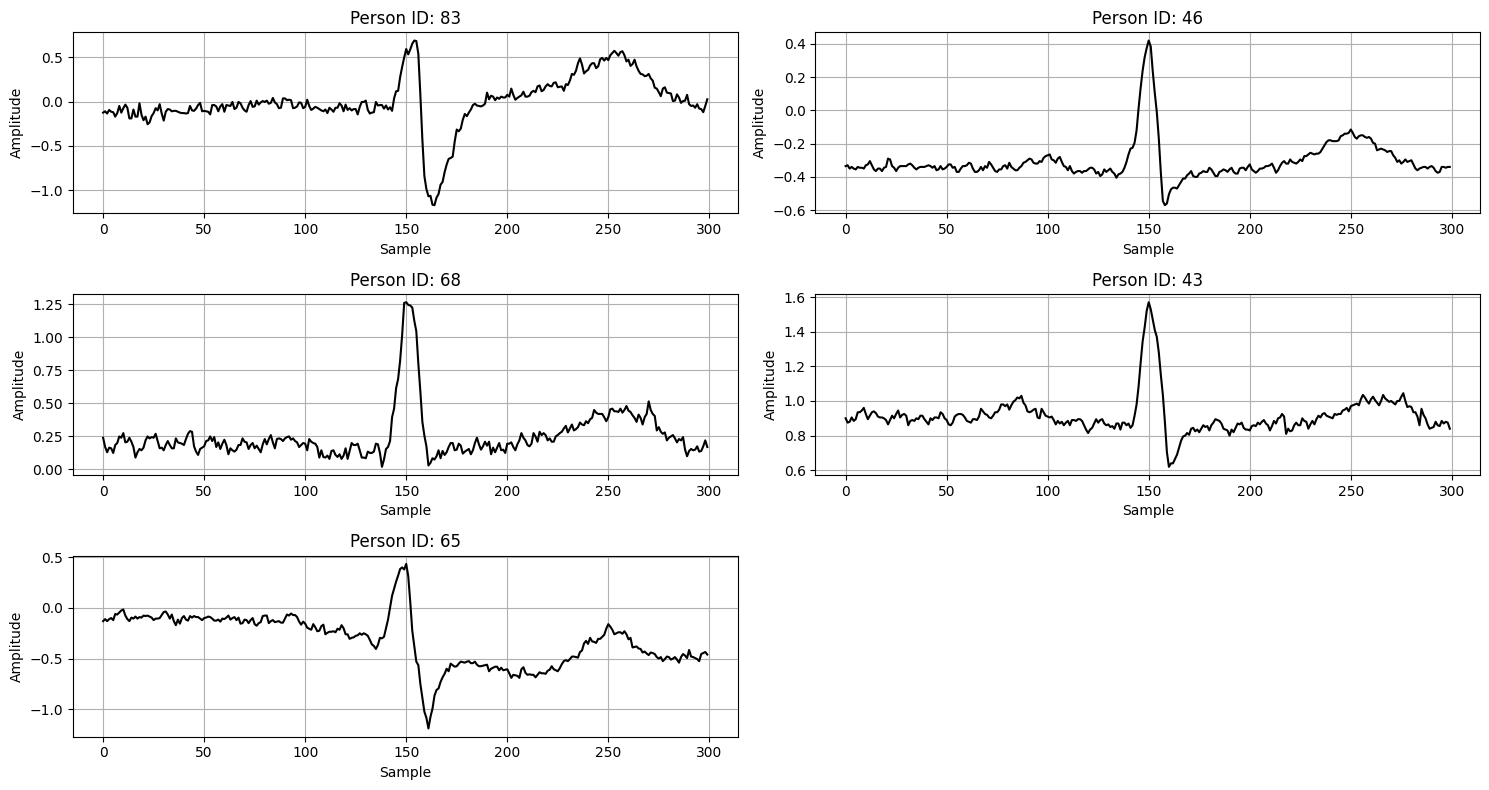

In [10]:
import random

# Plot 5 random heartbeats from 5 different people
plt.figure(figsize=(15, 8))
for i, person in enumerate(random.sample(list(np.unique(y)), 5)):
    idx = np.where(y == person)[0][0]  # Take first beat for this person
    plt.subplot(3, 2, i+1)
    plt.plot(X[idx], color='black')
    plt.title(f'Person ID: {person}')
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)
plt.tight_layout()
plt.show()


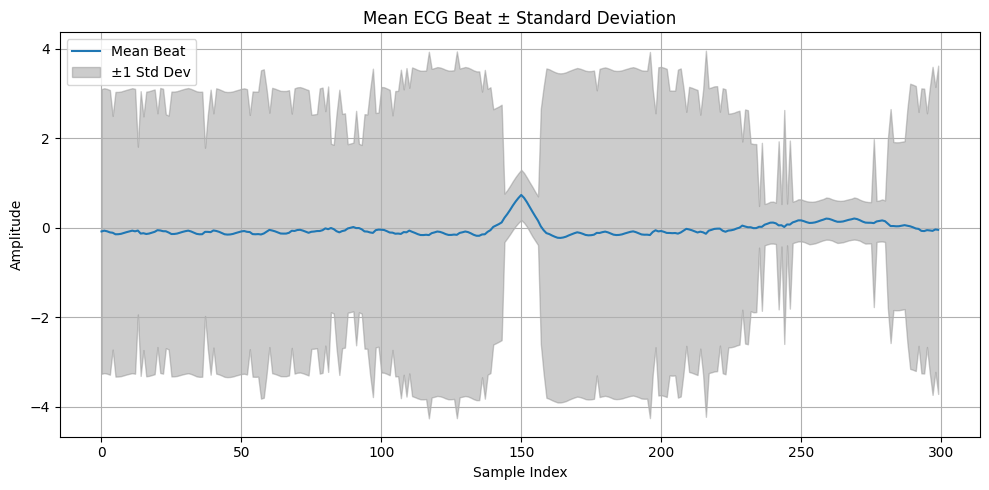

In [11]:
mean_beat = X.mean(axis=0)
std_beat = X.std(axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_beat, label='Mean Beat')
plt.fill_between(range(300), mean_beat - std_beat, mean_beat + std_beat, color='gray', alpha=0.4, label='±1 Std Dev')
plt.title("Mean ECG Beat ± Standard Deviation")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Model Development - embeddings and similarity Matching

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_embedding_model(input_length=300, embedding_dim=128):
    model = models.Sequential([
        layers.Input(shape=(input_length, 1)),

        layers.Conv1D(32, kernel_size=7, activation='relu'),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(64, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.GlobalMaxPooling1D(),

        layers.Dense(embedding_dim, activation='linear')  # Final embedding
    ])
    return model


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.load('X.npy')
y = np.load('y.npy')

# Reshape for CNN
X = X[..., np.newaxis]  # (7117, 300, 1)

# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [14]:
def build_classification_model(base_model, num_classes):
    inputs = layers.Input(shape=(300, 1))
    x = base_model(inputs)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

embedding_model = create_embedding_model()
full_model = build_classification_model(embedding_model, num_classes=len(np.unique(y)))

full_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

full_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128)            │        51,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │        11,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,386 (247.60 KB)

 Trainable params: 63,386 (247.60 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
full_model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.0672 - loss: 4.3881 - val_accuracy: 0.1088 - val_loss: 4.0064
Epoch 2/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1427 - loss: 3.7753 - val_accuracy: 0.2226 - val_loss: 3.1125
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3043 - loss: 2.7369 - val_accuracy: 0.4347 - val_loss: 2.2902
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4889 - loss: 2.0134 - val_accuracy: 0.5428 - val_loss: 1.8346
Epoch 5/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6212 - loss: 1.4350 - val_accuracy: 0.6770 - val_loss: 1.2593
Epoch 6/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7181 - loss: 1.0252 - val_accuracy: 0.7633 - val_loss: 0.9237
Epoch 7/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7845 - loss: 0.7781 - val_accuracy: 0.7872 - val_loss: 0.9009
Epoch 8/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8077 - loss: 0.6938 - val_accuracy: 0.8167 - v

In [16]:
full_model.save("ecg_auth_model.h5")

In [17]:
# Just get the embedding model (remove softmax)
embedding_only_model = models.Model(inputs=full_model.input, outputs=full_model.layers[-2].output)

# Extract embeddings from training samples
X_embeddings = embedding_only_model.predict(X)  # shape = (7117, 128)
np.save('embeddings.npy', X_embeddings)
np.save('labels.npy', y)

223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [18]:
val_embeddings = embedding_only_model.predict(X_val)
np.save("val_embeddings.npy", val_embeddings)
np.save("val_labels.npy", y_val)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [19]:
embedding_only_model.save("ecg_embedding_model.h5")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8647 - loss: 0.5810

Validation Loss: 0.6781
Validation Accuracy: 87.57%
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.78      0.84        98
           1       0.94      0.83      0.88        98
           2       0.92      1.00      0.96        23
           3       1.00      0.70      0.82        10
           4       1.00      0.86      0.92         7
           5       0.80      0.44      0.57         9
           6       0.86      0.67      0.75         9
           7       0.92      1.00      0.96        12
           8       0.51      0.93      0.66        28
           9       1.00      0.85      0.92        26
          10       0.93      0.93      0.93        14
          11       1.00      0.33      0.50        12
          12       1.00      0.83      0.91         6
          13       0.64      0.70      0.67        

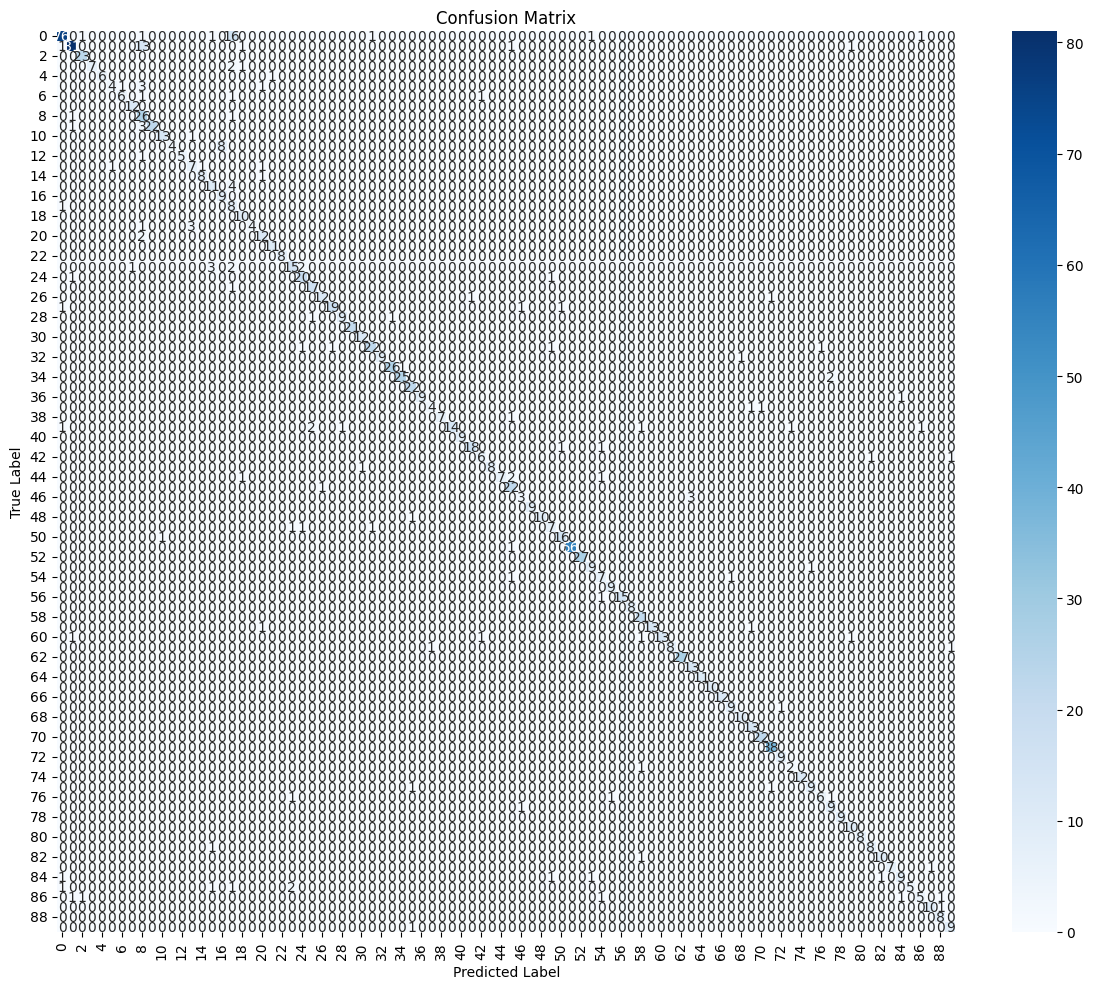

In [20]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load saved model
model = load_model("ecg_auth_model.h5")  # Update if filename is different

# Step 2: Load your validation data
# X_val = np.load("X_val.npy")
# y_val = np.load("y_val.npy")

# Step 3: Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"\nValidation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")

# Step 4: Predict and get detailed report
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# If labels are already integers (not one-hot), then this is enough:
y_true = y_val

# Step 5: Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# Step 6: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [21]:
np.save("test_beat_01.npy", X[100])  # for testing in GUI
np.save("test_beat_02.npy", X[105])  # for testing in GUI
np.save("test_beat_03.npy", X[200])  # for testing in GUI

In [25]:
import numpy as np
import os

# Load your dataset
X = np.load("X.npy")
y = np.load("y.npy")

# Choose a person ID (check dataset for valid IDs)
person_id = 30

# Get all beats of that person
person_beats = X[y == person_id]

# Pick first 4 beats
selected_beats = person_beats[:4]  # first 4 beats

# Create folder to store beats
os.makedirs("test_beats_person30", exist_ok=True)

# Save 3 beats for registration
for i in range(3):
    np.save(f"test_beats_person30/register_beat_{i+1}.npy", selected_beats[i])

# Save 1 beat for login
np.save("test_beats_person30/login_beat.npy", selected_beats[3])

print("Beats saved in 'test_beats_person30' folder:")
print("- register_beat_1.npy")
print("- register_beat_2.npy")
print("- register_beat_3.npy")
print("- login_beat.npy")


Beats saved in 'test_beats_person30' folder:
- register_beat_1.npy
- register_beat_2.npy
- register_beat_3.npy
- login_beat.npy
